In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
import pandas as pd
from arch import arch_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score, mean_absolute_error
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K


In [89]:
def read_data(window=22):
    price = pd.read_csv('dataset/kospi.csv')
    # oil = pd.read_csv('dataset/oilprice.csv')
    # gold = pd.read_csv('dataset/goldprice.csv')
    price = price.dropna()
    data = pd.DataFrame()
    data['Date'] = price['Date']
    data['Daily_trading_range'] = price['High'] - price['Low']
    data['Log_Volume_change'] = np.log((price['Volume'] / price['Volume'].shift(1))) * 100
    data['Daily_return'] = price['Close'].pct_change().dropna()
    data['Daily_log_return'] = np.log(price['Close'] / price['Close'].shift(1))
    data['Index'] = price['Close']
    # data['gold'] = gold['Close']
    # data['oil'] = oil['Close']
    data = data.dropna().reset_index(drop=True)

    # volatility = np.sqrt((data['Daily_log_return']**2).rolling(window=22).sum()/(21)) * np.sqrt(252)
    volatility = np.sqrt((data['Daily_log_return']**2).rolling(window=22).std()) * np.sqrt(252)
    data = data.iloc[22-window:].reset_index(drop=True)

    # target = yz_vol_measure(data)
    # target10 = yz_vol_measure(data, window=10)
    target = pd.DataFrame()
    target['Target'] = volatility[22:].reset_index(drop=True)
    # target['Target'] = volatility[22:].reset_index(drop=True)
    target = target.dropna()

    # data['Target10'] = target10
    # data = data.dropna()

    return data, target

In [3]:
def evaluate(predict, target, title):
    # rev_pred = scaler.inverse_transform(predict)
    # rev_true = scaler.inverse_transform(target)
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))
    # r2_test = r2_score(y_true=target, y_pred=predict)
    # print("test Score: {score} R2 score".format(score=r2_test))

In [4]:
def plot(predict, target, title, save=False):
    plt.plot(predict, label='predict')
    plt.plot(target, label='target')
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig('images/'+title)
    plt.show()

In [5]:
def garch_evaluate(predict, target, title):
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))


In [6]:
def ewma_estimation(data):
    sqreturn = np.array(data['Daily_log_return']**2)
    estimation = []
    estimation.append(data['Past_vol22'].iloc[0] / np.sqrt(252))
    weight = 0.94
    for i in range(1,len(data)):
        pred = weight*(estimation[-1]**2) + (1-weight)*(sqreturn[i-1])
        estimation.append(np.sqrt(pred))

    estimation = np.sqrt(252)*pd.DataFrame(estimation, columns=['EWMA'])

    # plot(estimation, np.array(data['Target22']))
    print('-----EWMA estimation done-----')
    return estimation

In [7]:
def create_gjr(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']].dropna())
    arr_target = np.array(target)
    gjr_pred = []
    mean_target = []
    target_window=22
    missing_values = target_window-window
    for i in range(len(target)):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
    for i in range(len(logreturns)-target_window+missing_values):
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=1, q=2, o=1, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean())* 0.01* np.sqrt(252))

    print('garch pred length: ', len(gjr_pred))
    print('target length: ', len(mean_target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(gjr_pred, mean_target, title)
    gjr_pred = pd.DataFrame(gjr_pred, columns=['GJR'])
    print('-----GJR-GARCH estimation done-----')
    return gjr_pred, mean_target

In [8]:
def create_garch(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    arr_target = np.array(target)
    garch_pred = []
    mean_target = []
    target_window = 22
    missing_values = target_window-window
    for i in range(len(target)):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
    for i in range(len(logreturns)-target_window+missing_values):
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=1, q=1, dist='skewt')
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        garch_pred.append(np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252))

    print('garch pred length: ', len(garch_pred))
    print('target length: ', len(mean_target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(garch_pred, mean_target, title)
    garch_pred = pd.DataFrame(garch_pred, columns=['GARCH'])
    print('-----GARCH estimation done-----')
    return garch_pred, mean_target

In [31]:
def data_prep(data, target, split_index, status=0, n_ahead=1, window=22):
    extras=pd.DataFrame()

    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead
    print(data.info())

    y_values = np.array(target)
    x_values = np.array(data)

    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    if(status==1):
        extras['GARCH'] = data['GARCH'].dropna()

    elif(status==2):
        extras['GJR'] = data['GJR'].dropna()

    elif(status==3):
        extras['GARCH'] = data['GARCH'].dropna()
        extras['GJR'] = data['GJR'].dropna()

    # trainX = np.array(scaled_x[:split_index])
    # testX = np.array(scaled_x[split_index:])
    # trainY = np.array(scaled_y[:split_index])
    # testY = np.array(scaled_y[split_index:])
    x = np.array([])
    y = np.array([])
    # Xtrain = np.array([])
    # ytrain = np.array([])
    # Xtest = np.array([])
    # ytest = np.array([])

    for i in range(len(data)-window-n_ahead):
        # candidate = trainX[i - window:i, :trainX.shape[1]]
        candidate = scaled_x[i:i+window, :scaled_x.shape[1]]

        if(status==1):
            candidate[:,-1] = extras['GARCH'].iloc[i]
        elif(status==2):
            candidate[:,-1] = extras['GJR'].iloc[i]
        elif(status==3):
            candidate[:,-1] = extras['GARCH'].iloc[i]
            candidate[:,-2] = extras['GJR'].iloc[i]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        # y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i-window:i-window+n_ahead].shape[1])
        y_candidate = scaled_y[i:i+n_ahead].reshape(1,scaled_y[i:i+n_ahead].shape[0], scaled_y[i:i+n_ahead].shape[1])
        if i==2429:
            print(y_candidate.shape)
        if i==0:
            x = candidate
            y = y_candidate
            continue

        x = np.append(x, candidate, axis=0)
        y = np.append(y, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])

    # for j in range(window, len(data)-n_ahead):
    #     test_candidate = testX[j - window:j, :testX.shape[1]]
    #     if(status==1):
    #         test_candidate[:,-1] = extras['GARCH'].iloc[split_index+j-window]
    #     elif(status==2):
    #         test_candidate[:,-1] = extras['GJR'].iloc[split_index+j-window]
    #     elif(status==3):
    #         test_candidate[:,-1] = extras['GARCH'].iloc[split_index+j-window]
    #         test_candidate[:,-2] = extras['GJR'].iloc[split_index+j-window]
    #     test_candidate = test_candidate.reshape(1, test_candidate.shape[0], test_candidate.shape[1])
    #     test_y_can = testY[j-window:j-window+n_ahead].reshape(1, testY[j-window:j-window+n_ahead].shape[0], testY[i-window:i-window+n_ahead].shape[1])
    #
    #     if(i==window):
    #         Xtest = test_candidate
    #         ytest = test_y_can
    #         continue
    #     Xtest = np.append(Xtest, test_candidate, axis=0)
    #     ytest = np.append(ytest, test_y_can, axis=0)

        # Xtest.append(test_candidate)
        # ytest.append(testY[i:i+n_ahead])
    # Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    # Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
    #
    # Xtest, ytest = (np.array(Xtest), np.array(ytest))
    # Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

    Xtrain, ytrain = (x[:split_index], y[:split_index])
    Xtest, ytest = (x[split_index:], y[split_index:])
    print(Xtrain.shape)
    print(ytrain.shape)
    print("-----")
    print(Xtest.shape)
    print(ytest.shape)
    return Xtrain, ytrain, Xtest, ytest, scaler

In [10]:
def create_lstm(output=1):
    model = Sequential()
    model.add(LSTM(units=32, return_sequences=True, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dropout(0.1))
    model.add(LSTM(units=20, return_sequences=False))
    model.add(Dropout(0.1))
    # model.add(LSTM(units=20, return_sequences=False))
    # model.add(Dropout(dropout3))
    # model.add(Dense(20, activation='tanh'))
    model.add(Dense(output))
    # model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.0002)
    model.compile(loss='mse', optimizer=opt)

    return model

In [11]:
def create_ann(output=1):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(output))
    adam = Adam(learning_rate=0.0003)
    model.compile(loss='mse', optimizer=adam)
    return model

In [12]:
def run_lstm(Xtrain, ytrain, Xtest, ytest, scaler):
    lstm = create_lstm(Xtrain)
    lstm_fit = lstm.fit(Xtrain, ytrain, batch_size=16, epochs=150)
    lstm_forecast = lstm.predict(Xtest)

    rev_forecast = scaler.inverse_transform(lstm_forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plot(rev_forecast, rev_ytest)
    evaluate(rev_forecast, rev_ytest, 'LSTM Evaluation')

In [13]:
def run_ann(Xtrain, ytrain, Xtest, ytest, scaler):
    model = create_ann(Xtrain)
    model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)
    forecast = model.predict(Xtest)

    rev_forecast = scaler.inverse_transform(forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plt.plot(rev_forecast, color='red', label='forecast')
    plt.plot(rev_ytest, color='gold', label='target')
    plt.legend()
    plt.show()
    evaluate(rev_forecast, rev_ytest, 'GER-FNN evaluation')

In [90]:
data, target = read_data(22)

split_index = int(len(data)*0.8)
print('Split index: ',split_index)
print('Observations: ', len(data))

Split index:  1964
Observations:  2455


In [91]:
data.head()

,Date,Daily_trading_range,Log_Volume_change,Daily_return,Daily_log_return,Index
0,2011-01-04,16.019776,16.086549,0.007275,0.007249,2085.139893
1,2011-01-05,10.219971,-7.434844,-0.001242,-0.001243,2082.550049
2,2011-01-06,30.549804,5.468045,-0.002372,-0.002375,2077.610107
3,2011-01-07,17.540039,-19.485688,0.004134,0.004126,2086.199951
4,2011-01-10,19.339844,2.064361,-0.002584,-0.002587,2080.810059


In [92]:
target

,Target
0,0.153070
1,0.153889
2,0.166514
3,0.170410
4,0.178958
...,...
2428,0.174849
2429,0.178117
2430,0.179110
2431,0.180236


In [93]:
window = 22
n_ahead=10

/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/changhyun/workspace/cxk858/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/ch

garch pred length:  2433
target length:  2433
-----GARCH estimation done-----
garch pred length:  2433
target length:  2433
-----GJR-GARCH estimation done-----
         GARCH
0     0.186691
1     0.190172
2     0.176069
3     0.165426
4     0.220882
...        ...
2428  0.157607
2429  0.156975
2430  0.167863
2431  0.161163
2432  0.155889

[2433 rows x 1 columns]
           GJR
0     0.162311
1     0.178467
2     0.191847
3     0.170374
4     0.194640
...        ...
2428  0.146616
2429  0.141759
2430  0.138405
2431  0.134821
2432  0.131498

[2433 rows x 1 columns]


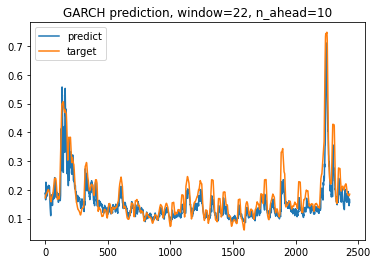

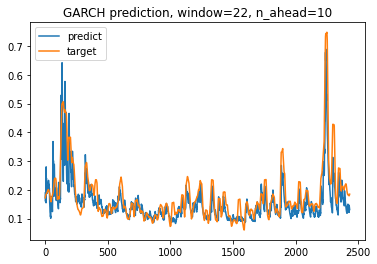

In [94]:
garch_estim, garch_y = create_garch(data, target, window=window, n_ahead=n_ahead)
gjr_estim, gjr_y = create_gjr(data, target, window=window, n_ahead=n_ahead)
print(garch_estim)
print(gjr_estim)


In [95]:
data_g = data.copy()
data_g['GARCH'] = garch_estim['GARCH']
data_r = data.copy()
data_r['GJR'] = gjr_estim['GJR']
data_gr = data.copy()
data_gr['GJR'] = gjr_estim['GJR']
data_gr['GARCH'] = garch_estim['GARCH']

In [76]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data_gr, target, split_index, status=3,n_ahead=n_ahead, window=window)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2455 entries, 0 to 2454
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2455 non-null   float64
 1   Log_Volume_change    2455 non-null   float64
 2   Daily_log_return     2455 non-null   float64
 3   Index                2455 non-null   float64
 4   GJR                  2433 non-null   float64
 5   GARCH                2433 non-null   float64
dtypes: float64(6)
memory usage: 115.2 KB
None
(1964, 22, 6)
(1964, 22, 1)
-----
(447, 22, 6)
(447, 22, 1)


In [77]:
Xtest

array([[[0.12146436, 0.49794526, 0.56372824, 0.39030816, 0.10618441,
         0.12709571],
        [0.06714407, 0.51048977, 0.59311563, 0.40927228, 0.10618441,
         0.12709571],
        [0.07787577, 0.49205161, 0.48092832, 0.40091679, 0.10618441,
         0.12709571],
        ...,
        [0.0919095 , 0.51608256, 0.51155516, 0.52775411, 0.10618441,
         0.12709571],
        [0.06830027, 0.4891679 , 0.51144553, 0.52677226, 0.10618441,
         0.12709571],
        [0.07738064, 0.49072253, 0.51504472, 0.52674398, 0.10618441,
         0.12709571]],

       [[0.06714407, 0.51048977, 0.59311563, 0.40927228, 0.12046805,
         0.13264781],
        [0.07787577, 0.49205161, 0.48092832, 0.40091679, 0.12046805,
         0.13264781],
        [0.1600445 , 0.4996134 , 0.62848123, 0.4287732 , 0.12046805,
         0.13264781],
        ...,
        [0.06830027, 0.4891679 , 0.51144553, 0.52677226, 0.12046805,
         0.13264781],
        [0.07738064, 0.49072253, 0.51504472, 0.52674398, 0.120

In [78]:
garch_estim.tail(50)

,GARCH
2383,0.147559
2384,0.144337
2385,0.142652
2386,0.138519
2387,0.137826
2388,0.135866
2389,0.134307
2390,0.134796
2391,0.169657
2392,0.173938


In [79]:
model = create_lstm(output=22)
# model = create_ann(output=22)
model_fit = model.fit(Xtrain, ytrain, batch_size=32, epochs=50,shuffle=False)

Epoch 1/50
62/62 [==============================] - 4s 15ms/step - loss: 0.0566

In [80]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(1964, 22, 6)
(1964, 22, 1)
(447, 22, 6)
(447, 22, 1)


In [81]:
forecast = model.predict(Xtest)

In [82]:
forecast = forecast.mean(axis=1).reshape(len(forecast),1)
ytest = ytest.mean(axis=1).reshape(len(ytest),1)

print(forecast.shape)
print(ytest.shape)

(447, 1)
(447, 1)


In [83]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

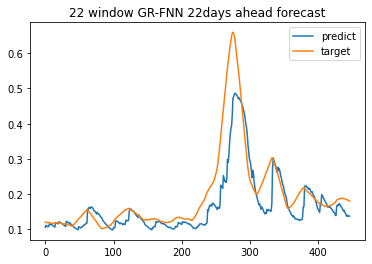

In [84]:
title = '{} window GR-FNN {}days ahead forecast'.format(window, n_ahead)
plot(rev_forecast, rev_ytest, title, save=False)

In [85]:
evaluate(rev_forecast, rev_ytest, 'ANN')

--------ANN----------
test Score: 0.004338831240988255 MSE
test Score: 0.06586980522962137 RMSE
test Score: 0.16628261270387998 MAPE
test Score: 0.038973334173644056 MAE


In [96]:
garch_test = np.array(garch_estim.iloc[split_index:])
gjr_test = np.array(gjr_estim.iloc[split_index:])
stat_test = np.array(garch_y[split_index:]).reshape(len(garch_y[split_index:]), 1)

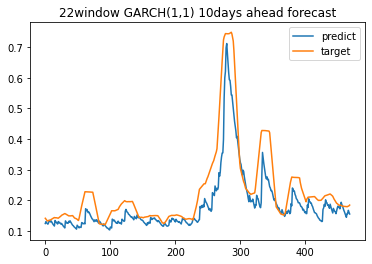

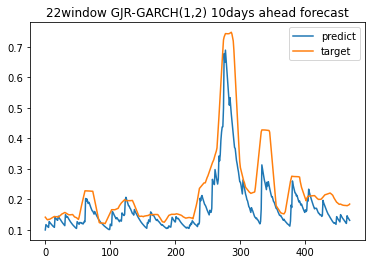

In [97]:
garch_title = '{}window GARCH(1,1) {}days ahead forecast'.format(window, n_ahead)
gjr_title = '{}window GJR-GARCH(1,2) {}days ahead forecast'.format(window,n_ahead)
plot(garch_test, stat_test, garch_title, True)
plot(gjr_test, stat_test, gjr_title, True)

In [98]:
garch_evaluate(garch_test, stat_test,'GARCH eval')
garch_evaluate(gjr_test, stat_test, 'GJR eval')

--------GARCH eval----------
test Score: 0.005437855141210575 MSE
test Score: 0.07374181406237966 RMSE
test Score: 0.1878789343165339 MAPE
test Score: 0.05010591442901233 MAE
--------GJR eval----------
test Score: 0.006764953461018265 MSE
test Score: 0.08224933714637624 RMSE
test Score: 0.21690797392398545 MAPE
test Score: 0.05721560417698283 MAE
